In [70]:
import warnings

warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from xgboost import XGBClassifier
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from category_encoders import TargetEncoder

In [71]:
DATA_PATH = 'flight-delays-spring-2018/'

In [72]:
train = pd.read_csv(DATA_PATH + "flight_delays_train.csv")
test = pd.read_csv(DATA_PATH + "flight_delays_test.csv")

In [73]:
train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [74]:
avg_dep_time_per_carrier = pd.DataFrame(train.groupby(['UniqueCarrier'])['DepTime'].mean().reset_index(name='avg_dep_time_carrier'))

In [77]:
avg_dep_time = train['DepTime'].mean()

In [79]:
avg_dep_time_per_origin = pd.DataFrame(train.groupby(['Origin'])['DepTime'].mean().reset_index(name='avg_dep_time_origin'))

In [80]:
avg_dep_time_per_origin

,Origin,avg_dep_time_origin
0,ABE,1242.895522
1,ABI,1016.160000
2,ABQ,1281.063745
3,ABY,1027.937500
4,ACK,1111.800000
...,...,...
284,WRG,1421.750000
285,WYS,1112.000000
286,XNA,1210.558376
287,YAK,1539.888889


In [81]:
train['hour'] = train['DepTime'].apply(lambda x: x // 100)
train['hour'] = train['hour'].apply(lambda x: x if x < 24 else x // 24)

In [82]:
avg_hour_per_carrier = pd.DataFrame(train.groupby(['UniqueCarrier'])['hour'].mean().reset_index(name='avg_hour_carrier'))

In [84]:
avg_hour = train['hour'].mean()

In [85]:
avg_hour_per_origin = pd.DataFrame(train.groupby(['Origin'])['hour'].mean().reset_index(name='avg_hour_origin'))

In [86]:
avg_hour_per_origin

,Origin,avg_hour_origin
0,ABE,12.134328
1,ABI,9.760000
2,ABQ,12.537849
3,ABY,10.000000
4,ACK,10.800000
...,...,...
284,WRG,14.000000
285,WYS,11.000000
286,XNA,11.837563
287,YAK,15.111111


In [29]:
avg_dist = pd.DataFrame(train.groupby(['UniqueCarrier'])['Distance'].mean().reset_index(name='avg_dist'))

In [18]:
avg_dist_all = train['Distance'].mean()

In [ ]:
pd.merge(avg_dist)

In [60]:
train[['UniqueCarrier']]

,UniqueCarrier
0,AA
1,US
2,XE
3,OO
4,WN
...,...
99995,OO
99996,CO
99997,NW
99998,MQ


In [30]:
num_of_flights = train[['UniqueCarrier']].value_counts().reset_index(name='num_of_flights')

In [62]:
train[['UniqueCarrier', 'Origin', 'Dest']].value_counts().reset_index(name='num_of_flights')

,UniqueCarrier,Origin,Dest,num_of_flights
0,WN,DAL,HOU,136
1,WN,HOU,DAL,129
2,MQ,SAN,LAX,111
3,HA,OGG,HNL,110
4,AA,DFW,ORD,109
...,...,...,...,...
7245,OH,PNS,CVG,1
7246,OH,PNS,JAX,1
7247,AQ,OGG,KOA,1
7248,UA,TUS,ORD,1


In [65]:
train[(train['UniqueCarrier'] == 'WN') & (train['Origin'] == 'DAL')]['Distance'].describe()

count    549.000000
mean     301.331512
std      117.816863
min      181.000000
25%      239.000000
50%      248.000000
75%      319.000000
max      580.000000
Name: Distance, dtype: float64

In [69]:
train[(train['UniqueCarrier'] == 'WN') & (train['Origin'] == 'DAL') & (train['Dest'] == 'HOU')]

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
841,c-10,c-25,c-3,2034,WN,DAL,HOU,239,Y
856,c-7,c-31,c-1,1927,WN,DAL,HOU,239,N
1044,c-4,c-10,c-1,1930,WN,DAL,HOU,239,N
1142,c-8,c-31,c-4,1405,WN,DAL,HOU,239,N
2573,c-4,c-7,c-5,930,WN,DAL,HOU,239,N
...,...,...,...,...,...,...,...,...,...
97093,c-4,c-29,c-5,930,WN,DAL,HOU,239,N
97481,c-8,c-12,c-6,932,WN,DAL,HOU,239,N
98104,c-6,c-7,c-2,715,WN,DAL,HOU,239,N
99008,c-10,c-22,c-6,1930,WN,DAL,HOU,239,N


In [67]:
train[(train['UniqueCarrier'] == 'WN') & (train['Origin'] == 'DAL') & (train['dep_delayed_15min'] == 'Y')]['Distance'].describe()

count    100.000000
mean     298.780000
std      115.507189
min      181.000000
25%      239.000000
50%      248.000000
75%      320.250000
max      580.000000
Name: Distance, dtype: float64

In [68]:
train[(train['UniqueCarrier'] == 'WN') & (train['Origin'] == 'DAL') & (train['dep_delayed_15min'] == 'N')]['Distance'].describe()

count    449.000000
mean     301.899777
std      118.444537
min      181.000000
25%      239.000000
50%      248.000000
75%      319.000000
max      580.000000
Name: Distance, dtype: float64

In [66]:
train[(train['UniqueCarrier'] == 'WN') & (train['Origin'] == 'DAL')]['dep_delayed_15min'].value_counts()

N    449
Y    100
Name: dep_delayed_15min, dtype: int64

In [59]:
train[['UniqueCarrier']].value_counts().reset_index(name='num_of_flights')

,UniqueCarrier,num_of_flights
0,WN,15082
1,AA,9418
2,DL,8128
3,MQ,7443
4,OO,7390
5,UA,6876
6,US,6482
7,NW,6403
8,XE,5901
9,OH,4594


In [23]:
dist_stat = pd.merge(avg_dist, num_of_flights, on='UniqueCarrier')

In [87]:
dist_stat

,UniqueCarrier,avg_dist,num_of_flights,smoothed_avg
0,AA,1079.926630,9418,1044.873683
1,AQ,506.307692,234,528.616639
2,AS,868.553555,2222,854.637916
3,B6,1276.878128,1838,1222.130032
4,CO,1113.829257,4334,1075.386047
5,DH,453.467909,966,481.060834
6,DL,888.395423,8128,872.495597
7,EV,475.270483,3930,500.683151
8,F9,892.682903,1006,876.354328
9,FL,657.792695,3039,664.953141


In [46]:

smoove = 0.9
dist_stat['smoothed_avg'] = prior * (1 - smoove) + dist_stat['avg_dist'] * smoove


In [58]:
dist_stat[['UniqueCarrier', 'smoothed_avg']].set_index('UniqueCarrier').T.to_dict('list')

{'AA': [1044.8736828719475],
 'AQ': [528.6166390769231],
 'AS': [854.637915819982],
 'B6': [1222.1300315603917],
 'CO': [1075.386047333641],
 'DH': [481.0608340124224],
 'DL': [872.4955969055118],
 'EV': [500.6831511145038],
 'F9': [876.3543283260437],
 'FL': [664.9531414689043],
 'HA': [589.995621511811],
 'HP': [985.033547640058],
 'MQ': [439.44576194921405],
 'NW': [760.3052633996564],
 'OH': [489.35917616543315],
 'OO': [420.61641424086605],
 'TZ': [1143.1769357309418],
 'UA': [1073.4539830157069],
 'US': [745.4985250095649],
 'WN': [631.2737698390133],
 'XE': [550.2850134072191],
 'YV': [446.0303175037594]}

In [34]:
dist_stat

,UniqueCarrier,avg_dist,num_of_flights,smoothed_avg
0,AA,1079.926630,9418,1079.926630
1,AQ,506.307692,234,506.307692
2,AS,868.553555,2222,868.553555
3,B6,1276.878128,1838,1276.878128
4,CO,1113.829257,4334,1113.829257
5,DH,453.467909,966,453.467909
6,DL,888.395423,8128,888.395423
7,EV,475.270483,3930,475.270483
8,F9,892.682903,1006,892.682903
9,FL,657.792695,3039,657.792695


# Departure time investigation

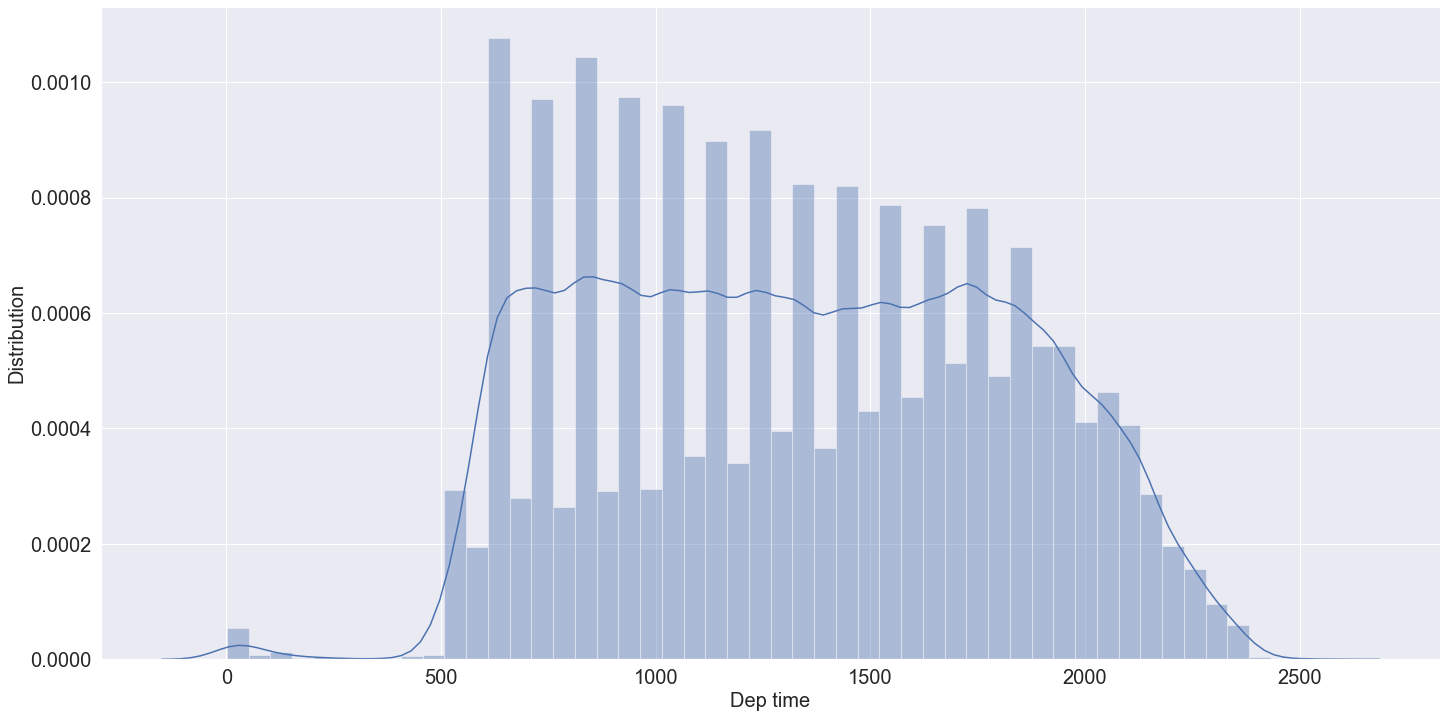

In [5]:
sns.set(rc={"figure.figsize": (24, 12)})
ax = sns.distplot(train['DepTime'])
plt.xlabel('Dep time', fontsize=20);
plt.ylabel('Distribution', fontsize=20);
plt.tick_params(axis='both', which='major', labelsize=20)
plt.show()

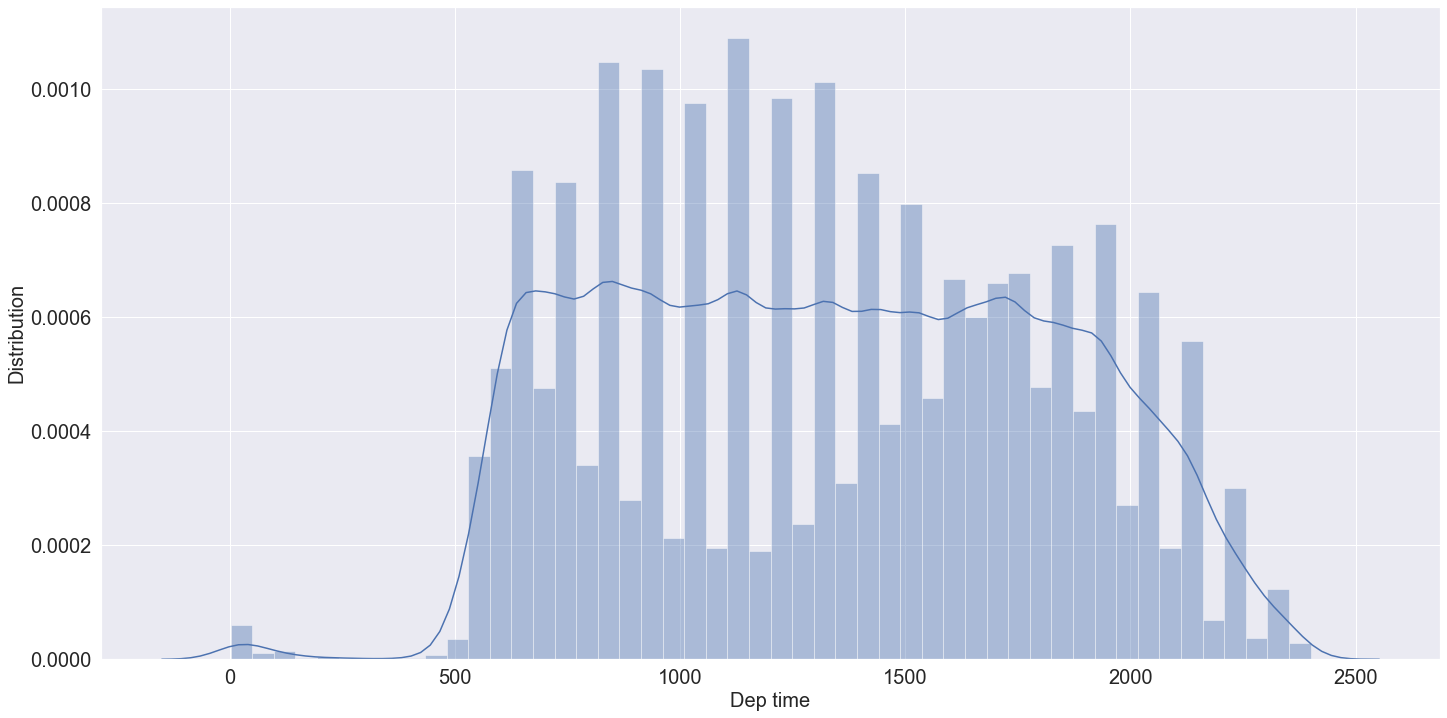

In [6]:
sns.set(rc={"figure.figsize": (24, 12)})
ax = sns.distplot(test['DepTime'])
plt.xlabel('Dep time', fontsize=20);
plt.ylabel('Distribution', fontsize=20);
plt.tick_params(axis='both', which='major', labelsize=20)
plt.show()

In [13]:
dep_times = sorted(train['DepTime'].unique())

In [23]:
train['hour'] = train['DepTime'].apply(lambda x: x // 100)

In [24]:
train

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min,hour
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N,19
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N,15
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N,14
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N,10
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y,18
...,...,...,...,...,...,...,...,...,...,...
99995,c-5,c-4,c-3,1618,OO,SFO,RDD,199,N,16
99996,c-1,c-18,c-3,804,CO,EWR,DAB,884,N,8
99997,c-1,c-24,c-2,1901,NW,DTW,IAH,1076,N,19
99998,c-4,c-27,c-4,1515,MQ,DFW,GGG,140,N,15


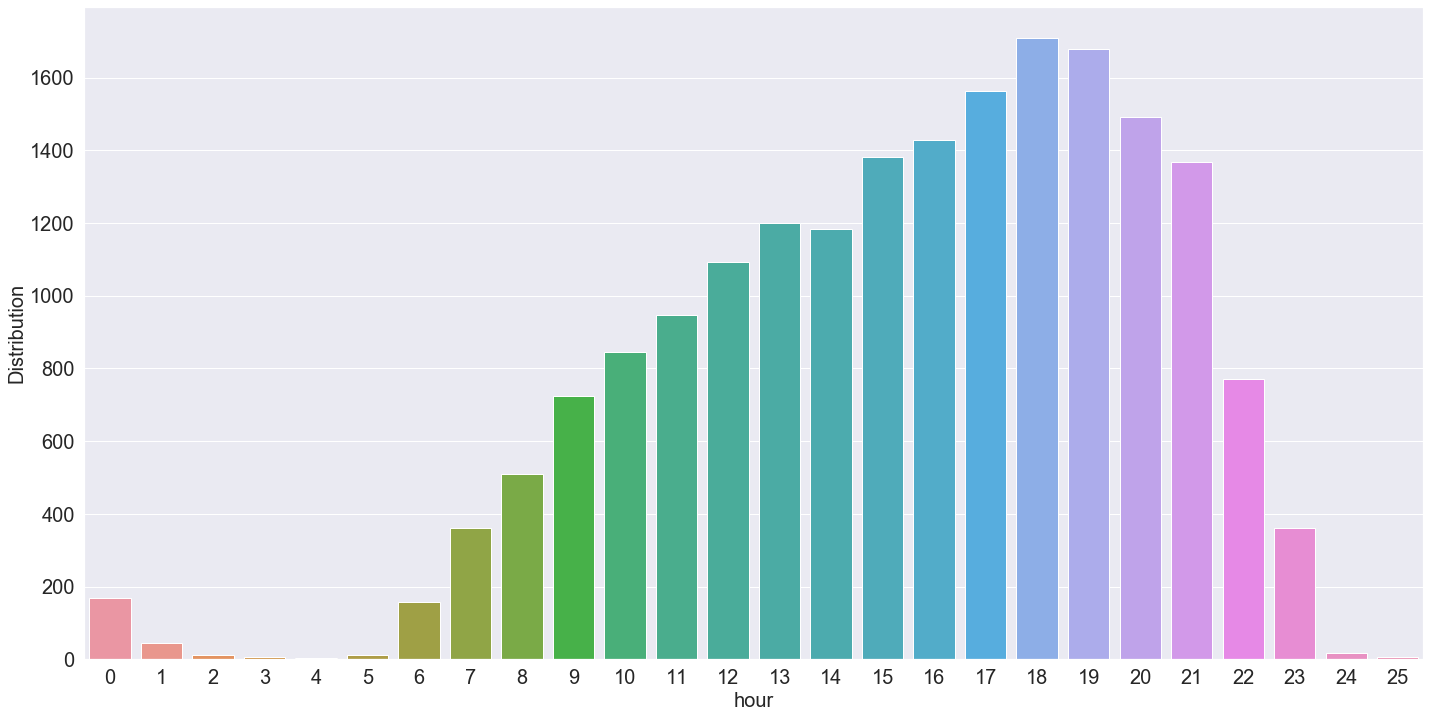

In [25]:
delayed_flights = train[train['dep_delayed_15min'] == 'Y']

sns.set(rc={"figure.figsize": (24, 12)})
ax = sns.countplot(delayed_flights['hour'])
plt.xlabel('hour', fontsize=20);
plt.ylabel('Distribution', fontsize=20);
plt.tick_params(axis='both', which='major', labelsize=20)
plt.show()

In [39]:
def count_flight_ratio_per_column(df, column):
    grouped = pd.DataFrame(df[[column, 'dep_delayed_15min']].value_counts().reset_index(name='num_of_flights'))
    delayed_count = grouped[grouped.dep_delayed_15min == 'Y']
    total_flights = grouped.groupby(column)['num_of_flights'].sum().reset_index(name='total')
    final_table = pd.merge(delayed_count, total_flights, on=column)
    final_table['ratio'] = final_table.apply(lambda x: float(x['num_of_flights']) / x['total'], axis=1)
    return final_table

In [27]:
grouped = pd.DataFrame(train[['hour', 'dep_delayed_15min']].value_counts().reset_index(name='num_of_flights'))

In [29]:
delayed_count = grouped[grouped.dep_delayed_15min == 'Y']

In [34]:
total_flights = grouped.groupby('hour')['num_of_flights'].sum().reset_index(name='total')

In [36]:
final_table = pd.merge(delayed_count, total_flights, on='hour')

In [37]:
final_table['ratio'] = final_table.apply(lambda x: float(x['num_of_flights']) / x['total'], axis=1)

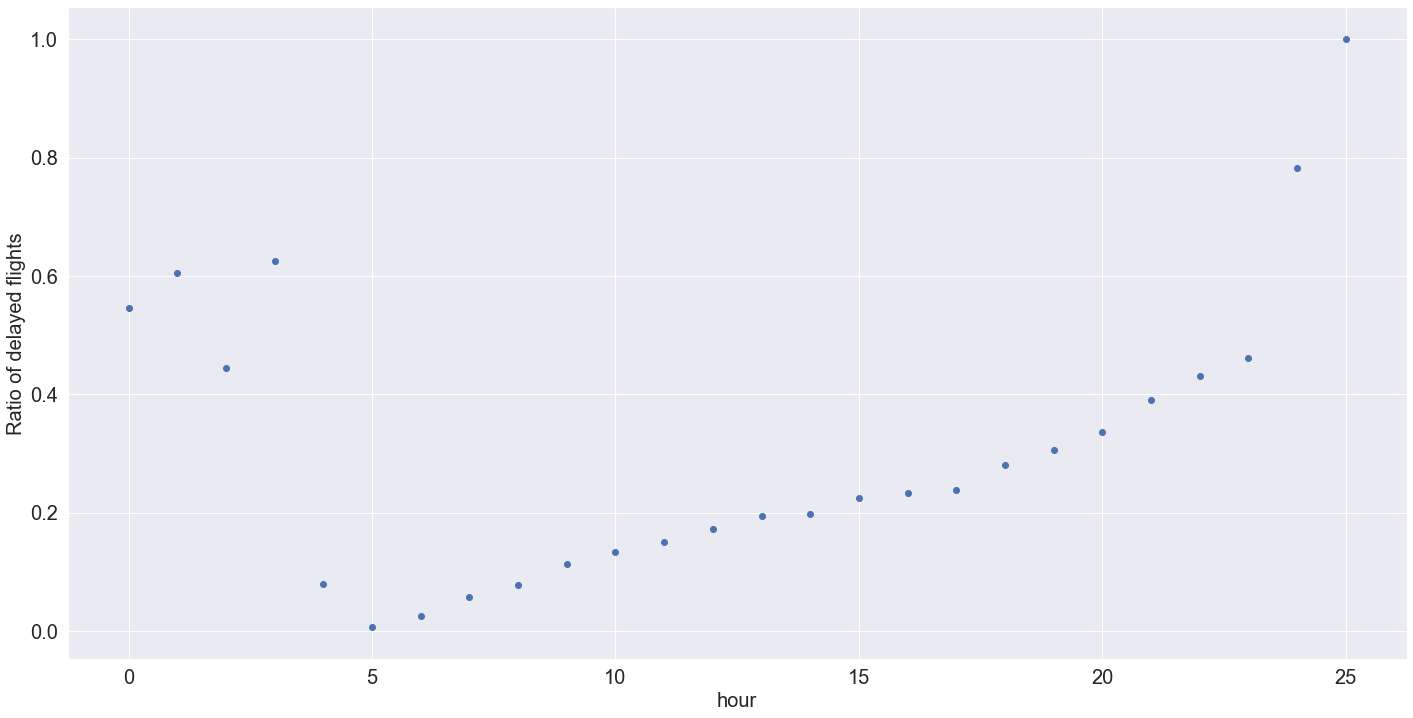

In [42]:
plt.scatter(final_table['hour'].values, final_table['ratio'].values)
plt.xlabel('hour', fontsize=20);
plt.ylabel('Ratio of delayed flights', fontsize=20);
plt.tick_params(axis='both', which='major', labelsize=20)
plt.show()

Makes sense to try to add variable day/evening/morning/night as well as time of departure and see it's performance

# Month

In [48]:
train['Month'].values[0].split('-')[1]

'8'

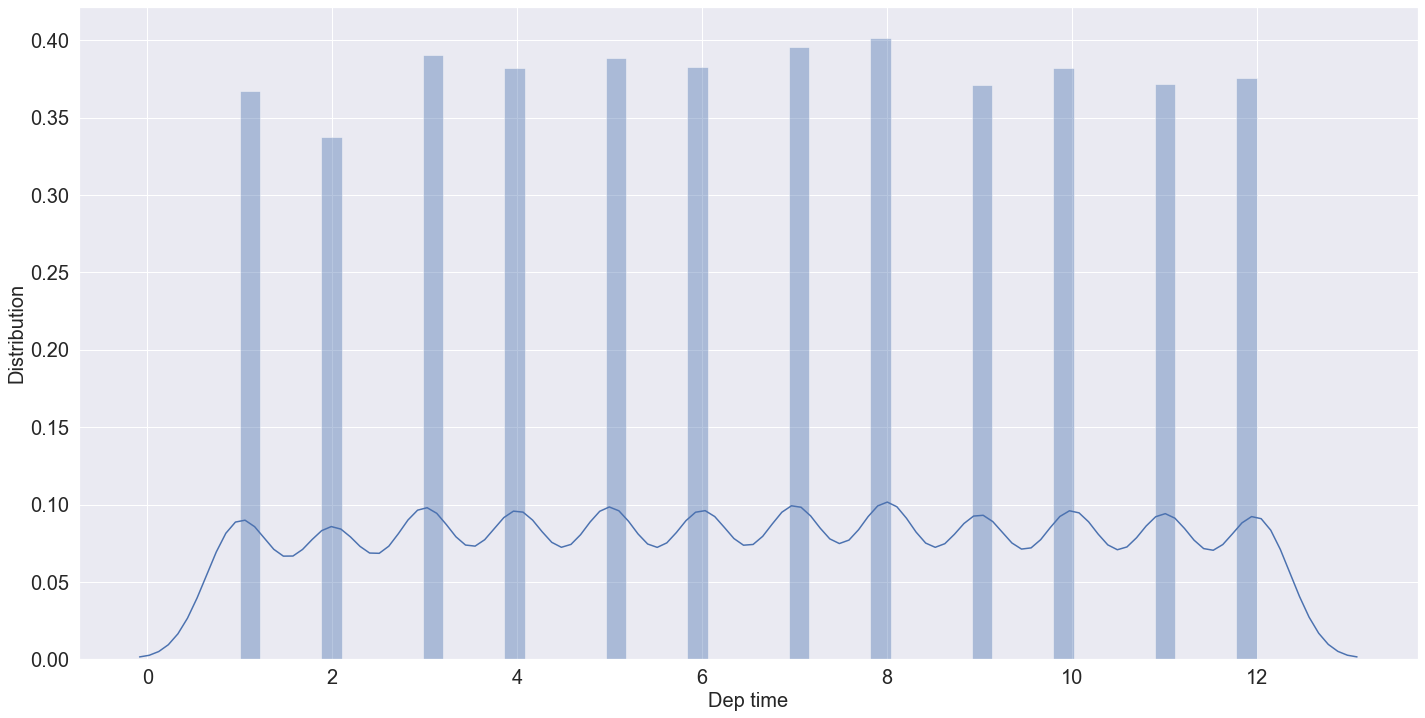

In [49]:
month_values = [int(x.split('-')[1]) for x in train['Month'].values]
sns.set(rc={"figure.figsize": (24, 12)})
ax = sns.distplot(month_values)
plt.xlabel('Dep time', fontsize=20);
plt.ylabel('Distribution', fontsize=20);
plt.tick_params(axis='both', which='major', labelsize=20)
plt.show()

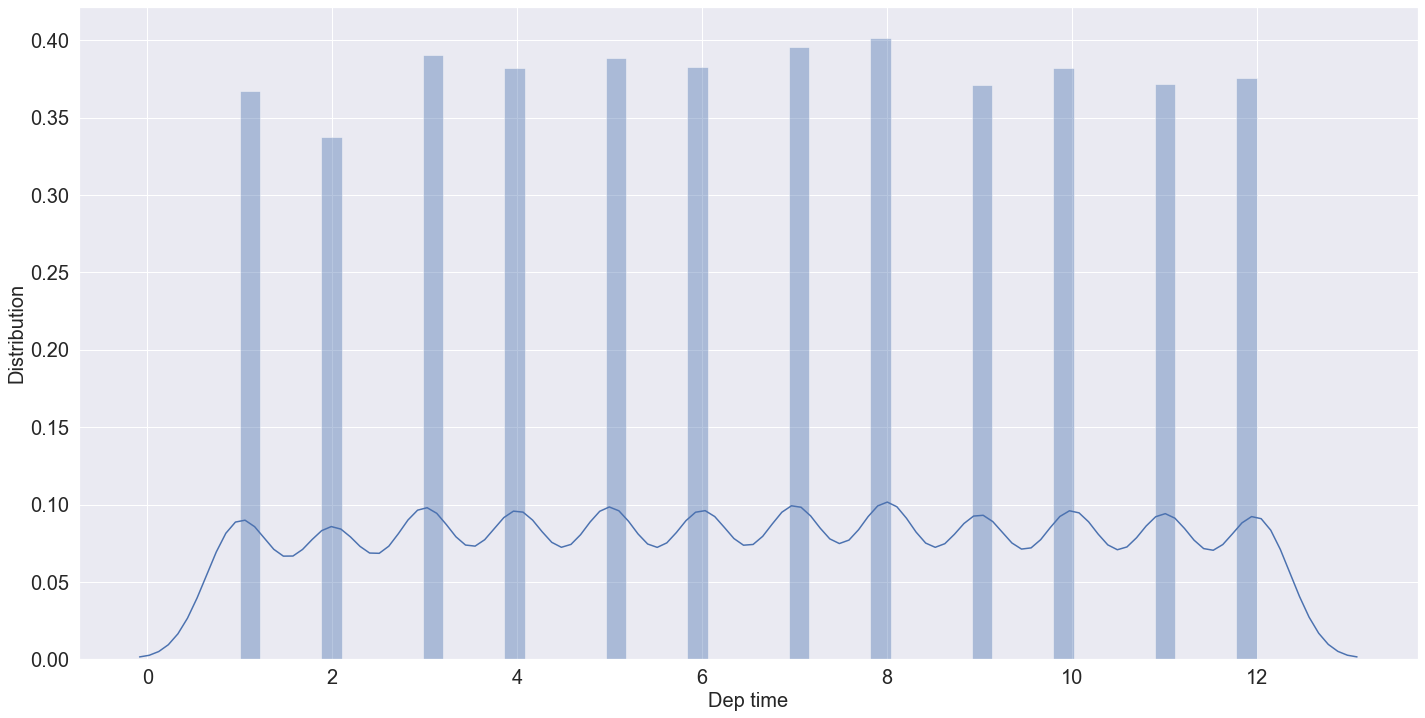

In [50]:
test_month_values = [int(x.split('-')[1]) for x in train['Month'].values]
sns.set(rc={"figure.figsize": (24, 12)})
ax = sns.distplot(test_month_values)
plt.xlabel('Dep time', fontsize=20);
plt.ylabel('Distribution', fontsize=20);
plt.tick_params(axis='both', which='major', labelsize=20)
plt.show()

In [52]:
month_stat = count_flight_ratio_per_column(train, 'Month')

In [53]:
month_stat

,Month,dep_delayed_15min,num_of_flights,total,ratio
0,c-7,Y,2073,8706,0.238112
1,c-12,Y,1994,8265,0.241258
2,c-6,Y,1867,8414,0.221892
3,c-8,Y,1783,8830,0.201925
4,c-3,Y,1676,8595,0.194997
5,c-1,Y,1539,8075,0.190588
6,c-10,Y,1501,8405,0.178584
7,c-11,Y,1397,8178,0.170824
8,c-2,Y,1316,7418,0.177406
9,c-5,Y,1313,8543,0.153693


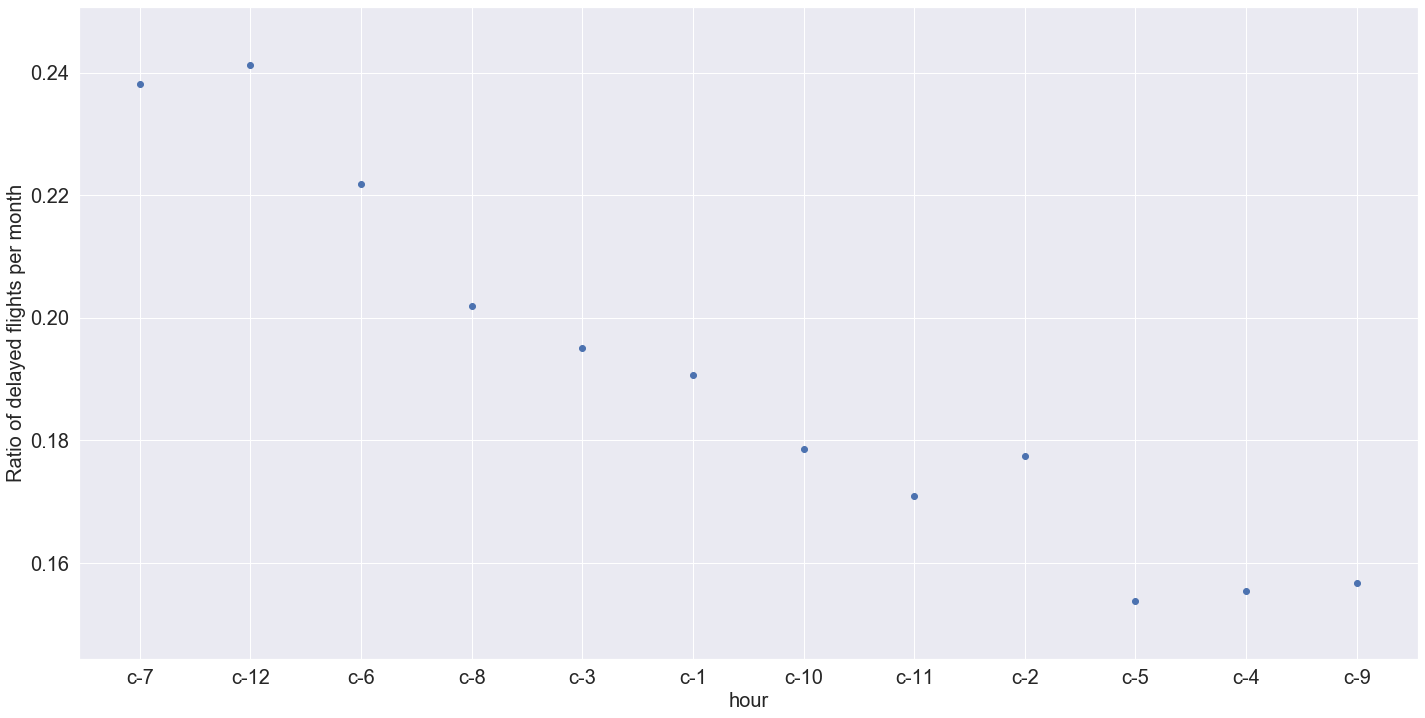

In [54]:
plt.scatter(month_stat['Month'].values, month_stat['ratio'].values)
plt.xlabel('hour', fontsize=20);
plt.ylabel('Ratio of delayed flights per month', fontsize=20);
plt.tick_params(axis='both', which='major', labelsize=20)
plt.show()

Not sure if seasons(Summer/Winter) feature will help. I can try and see. Maybe only summer

# Day of Month

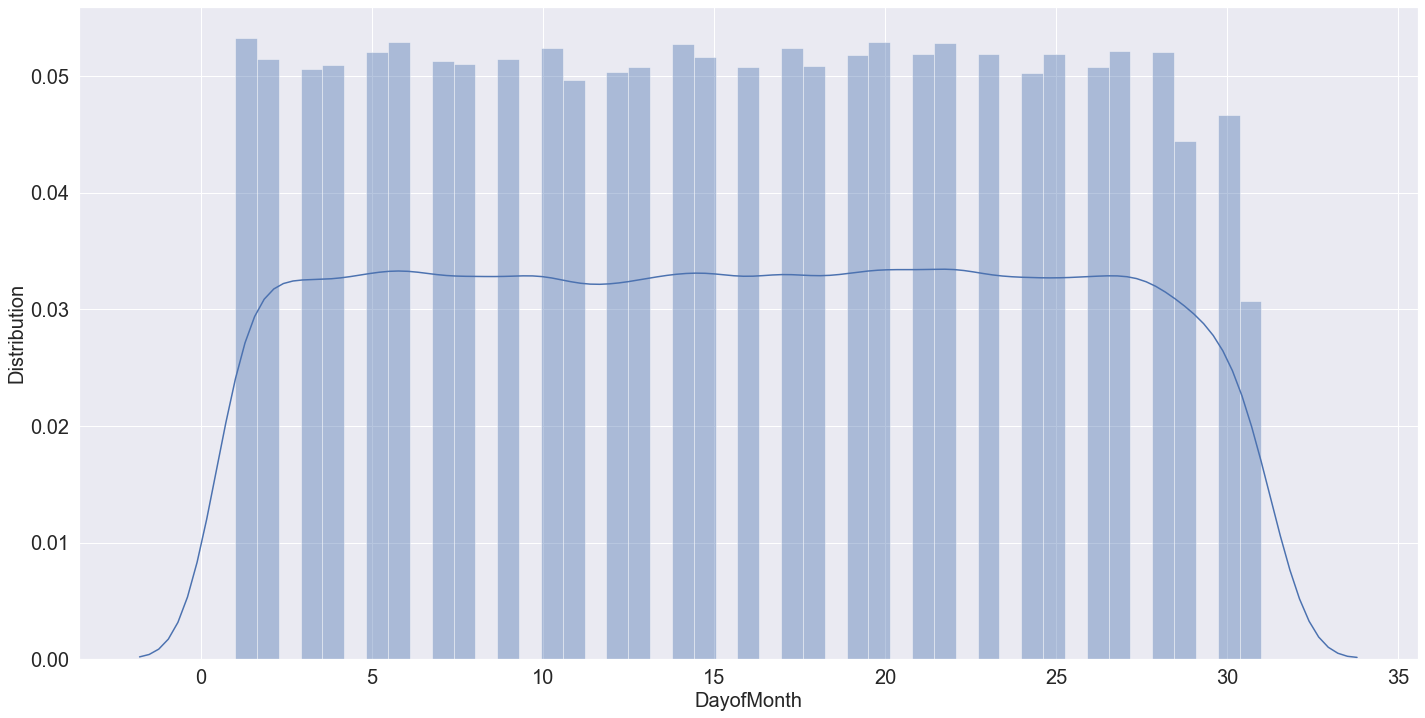

In [55]:
daymonth_values = [int(x.split('-')[1]) for x in train['DayofMonth'].values]
sns.set(rc={"figure.figsize": (24, 12)})
ax = sns.distplot(daymonth_values)
plt.xlabel('DayofMonth', fontsize=20);
plt.ylabel('Distribution', fontsize=20);
plt.tick_params(axis='both', which='major', labelsize=20)
plt.show()

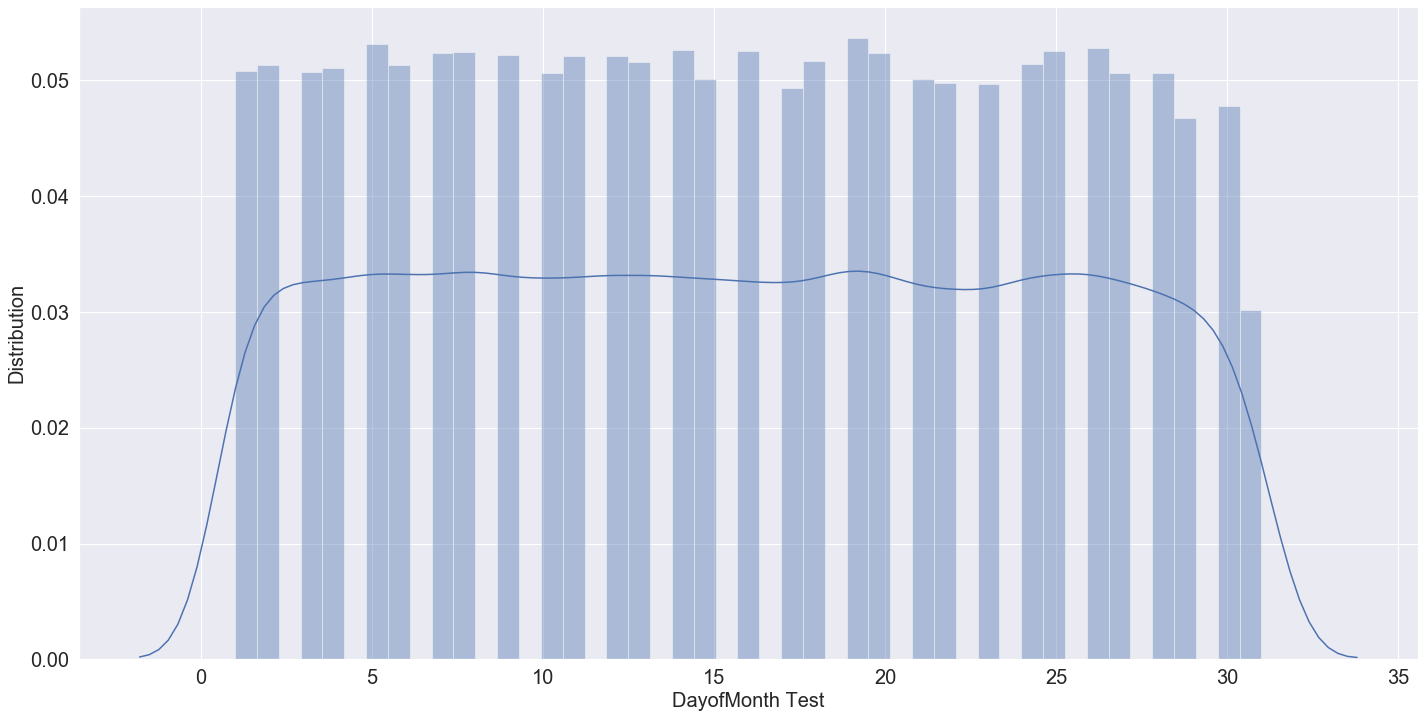

In [56]:
test_daymonth_values = [int(x.split('-')[1]) for x in test['DayofMonth'].values]
sns.set(rc={"figure.figsize": (24, 12)})
ax = sns.distplot(test_daymonth_values)
plt.xlabel('DayofMonth Test', fontsize=20);
plt.ylabel('Distribution', fontsize=20);
plt.tick_params(axis='both', which='major', labelsize=20)
plt.show()

In [60]:
day_month_stat = count_flight_ratio_per_column(train, 'DayofMonth')
day_month_stat['num_day_month'] = day_month_stat['DayofMonth'].apply(lambda x: int(x.split('-')[1]))
day_month_stat = day_month_stat.sort_values(by='num_day_month')

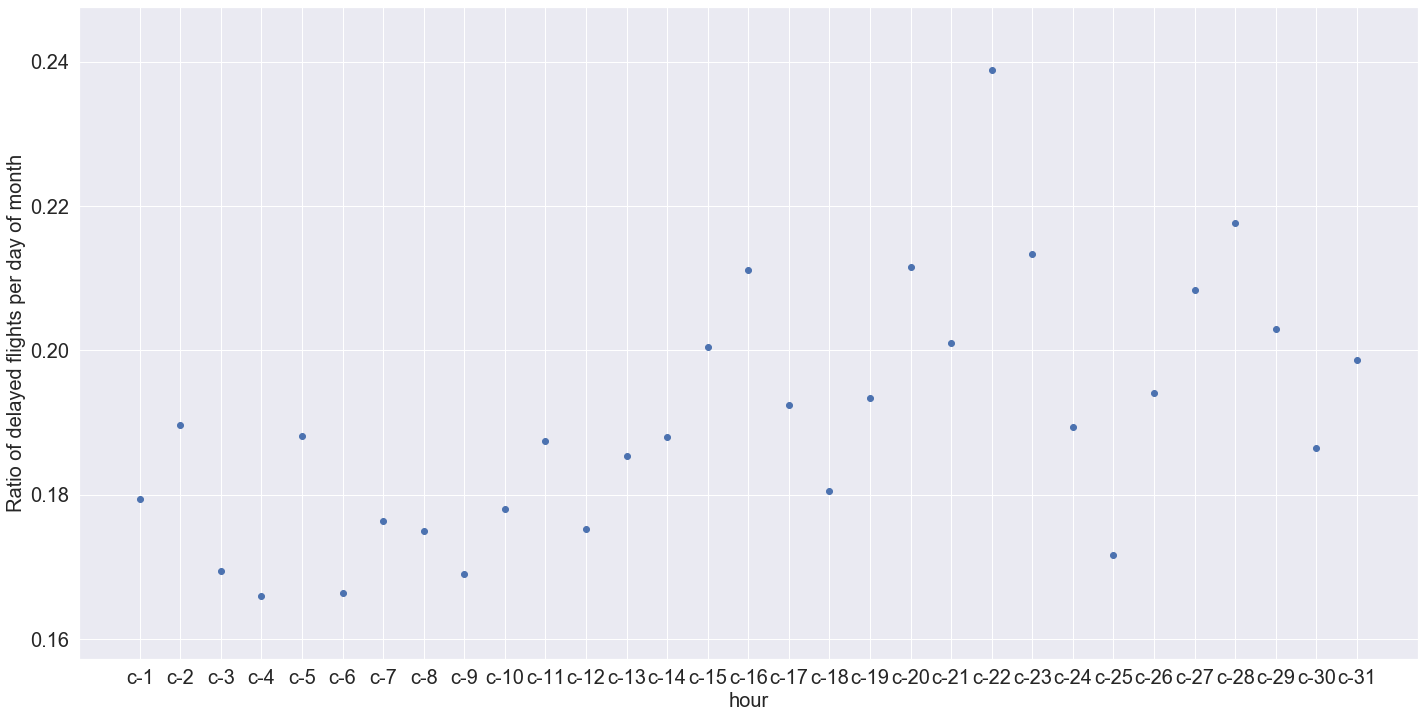

In [61]:
plt.scatter(day_month_stat['DayofMonth'].values, day_month_stat['ratio'].values)
plt.xlabel('hour', fontsize=20);
plt.ylabel('Ratio of delayed flights per day of month', fontsize=20);
plt.tick_params(axis='both', which='major', labelsize=20)
plt.show()

Probably can try to make first/second half of the month feature

# Day Of Week

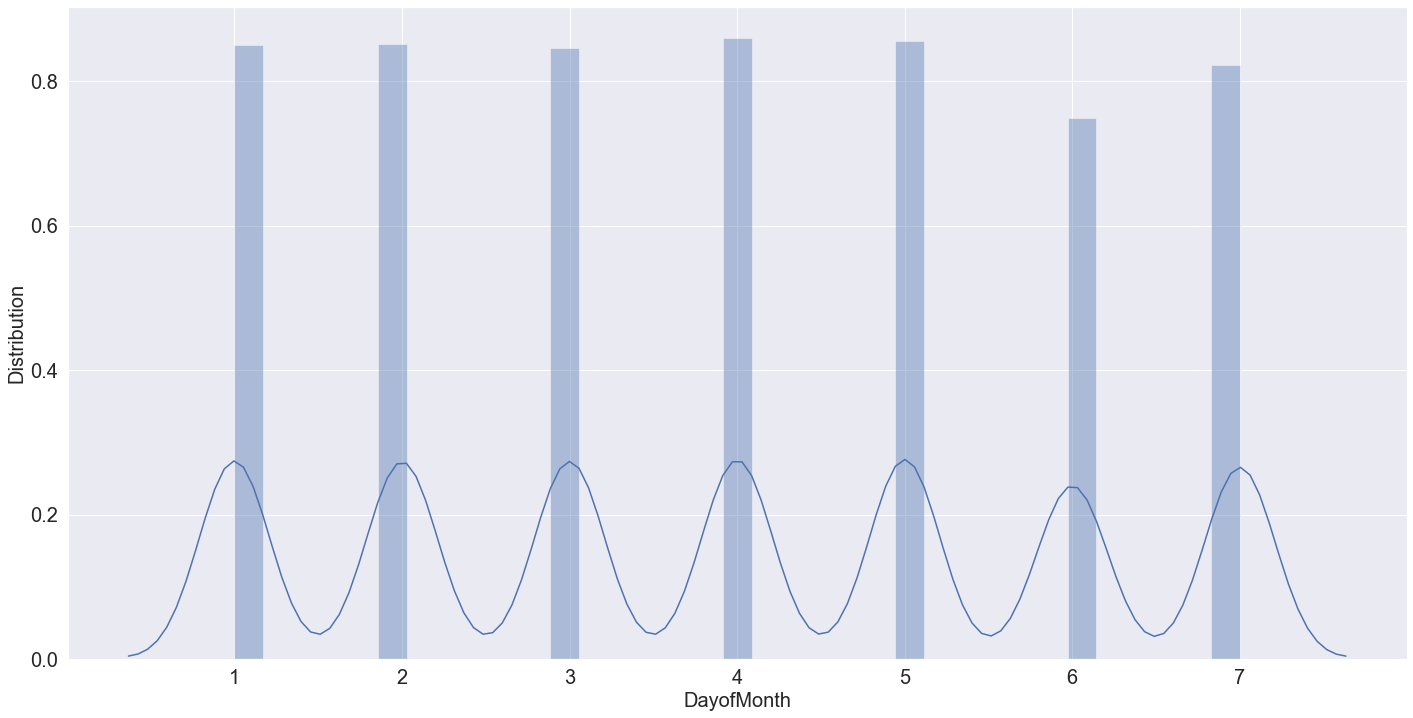

In [62]:
day_week_values = [int(x.split('-')[1]) for x in train['DayOfWeek'].values]
sns.set(rc={"figure.figsize": (24, 12)})
ax = sns.distplot(day_week_values)
plt.xlabel('DayofMonth', fontsize=20);
plt.ylabel('Distribution', fontsize=20);
plt.tick_params(axis='both', which='major', labelsize=20)
plt.show()

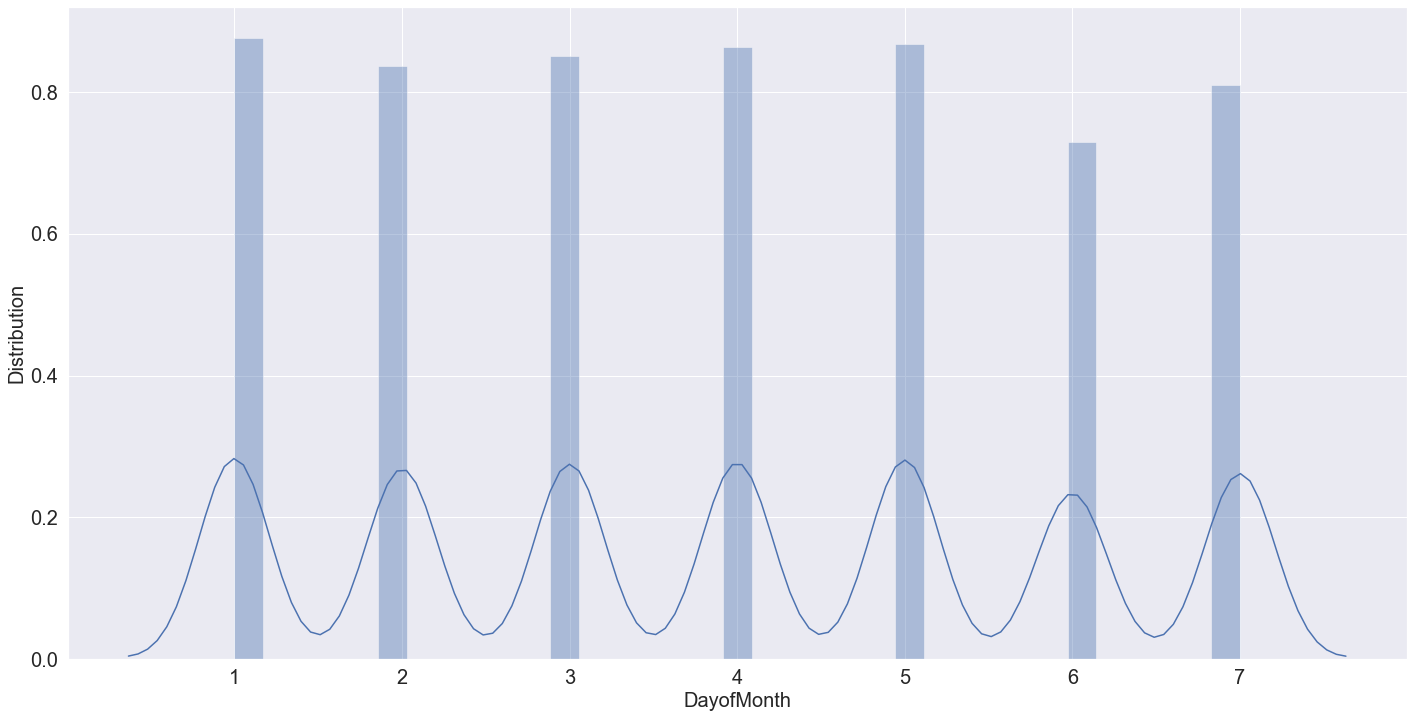

In [65]:
test_day_week_values = [int(x.split('-')[1]) for x in test['DayOfWeek'].values]
sns.set(rc={"figure.figsize": (24, 12)})
ax = sns.distplot(test_day_week_values)
plt.xlabel('DayofMonth', fontsize=20);
plt.ylabel('Distribution', fontsize=20);
plt.tick_params(axis='both', which='major', labelsize=20)
plt.show()

In [66]:
day_week_stat = count_flight_ratio_per_column(train, 'DayOfWeek')
day_week_stat['num_day_week'] = day_week_stat['DayOfWeek'].apply(lambda x: int(x.split('-')[1]))
day_week_stat = day_week_stat.sort_values(by='num_day_week')

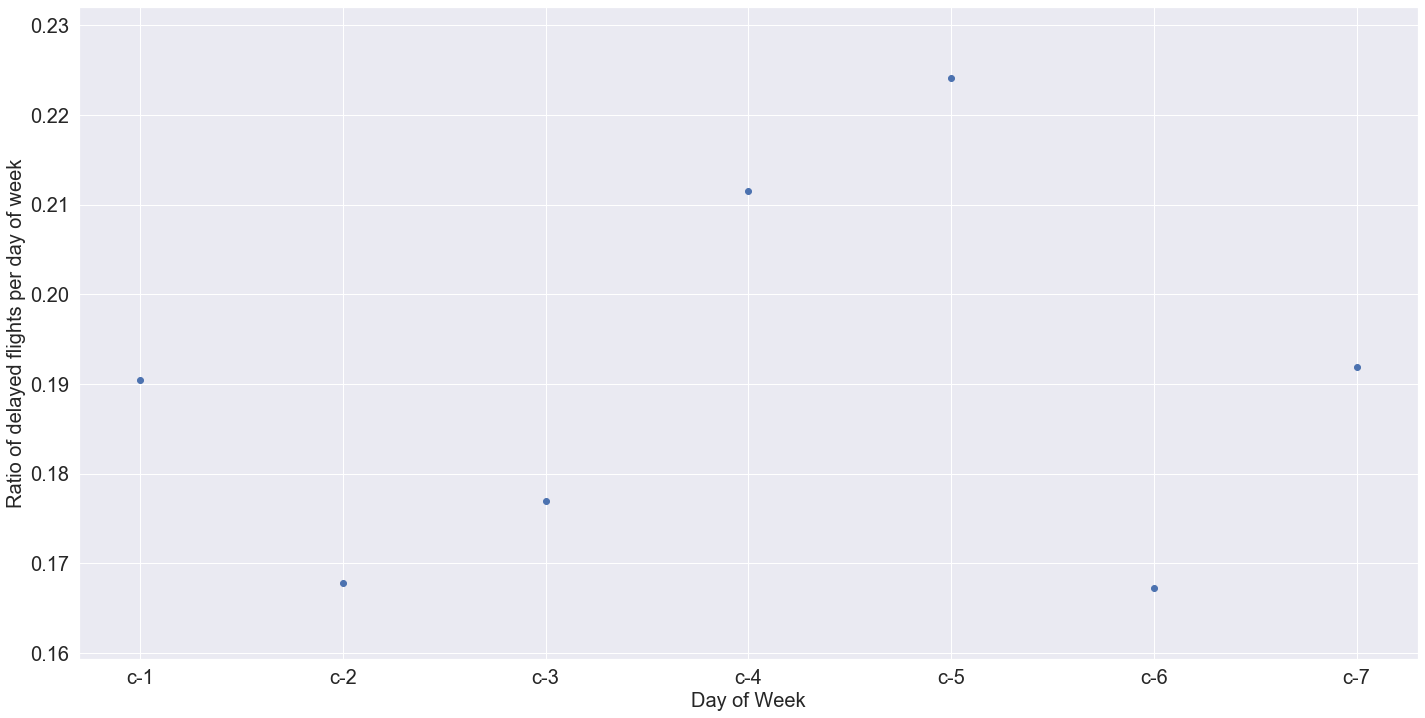

In [68]:
plt.scatter(day_week_stat['DayOfWeek'].values, day_week_stat['ratio'].values)
plt.xlabel('Day of Week', fontsize=20);
plt.ylabel('Ratio of delayed flights per day of week', fontsize=20);
plt.tick_params(axis='both', which='major', labelsize=20)
plt.show()

Probably some feature like 'before weekends' with c-4 and c-5 will be helpful

# Unique Carrier

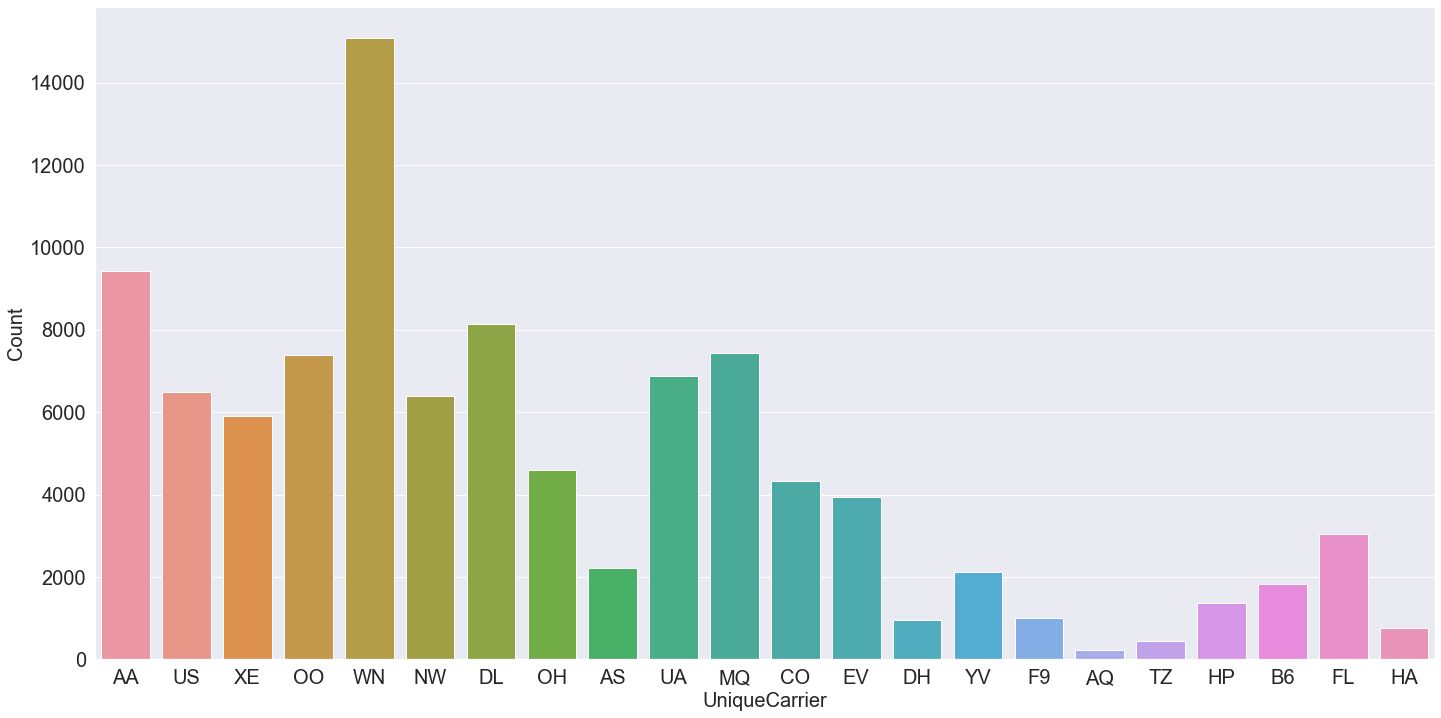

In [69]:
sns.set(rc={"figure.figsize": (24, 12)})
ax = sns.countplot(train['UniqueCarrier'])
plt.xlabel('UniqueCarrier', fontsize=20);
plt.ylabel('Count', fontsize=20);
plt.tick_params(axis='both', which='major', labelsize=20)
plt.show()

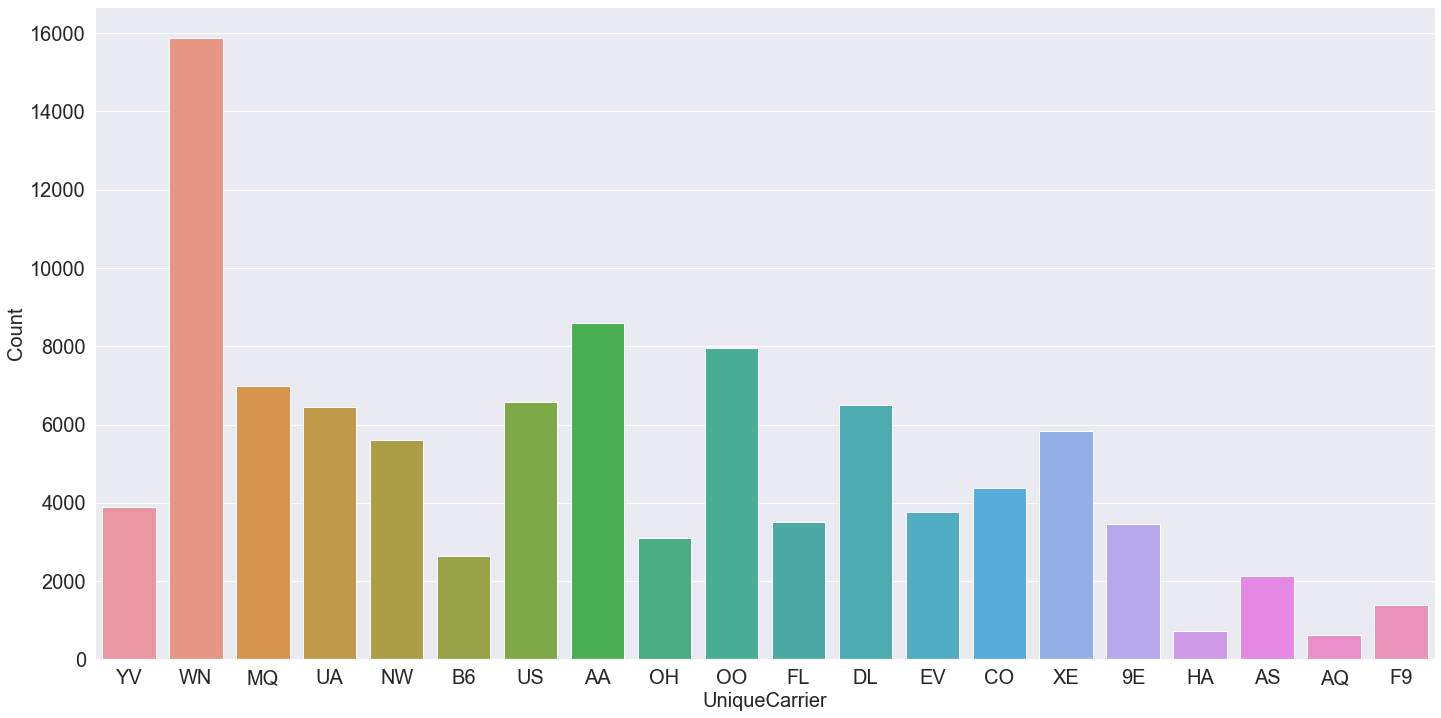

In [70]:
sns.set(rc={"figure.figsize": (24, 12)})
ax = sns.countplot(test['UniqueCarrier'])
plt.xlabel('UniqueCarrier', fontsize=20);
plt.ylabel('Count', fontsize=20);
plt.tick_params(axis='both', which='major', labelsize=20)
plt.show()

In [71]:
uniq_carr = count_flight_ratio_per_column(train, 'UniqueCarrier')

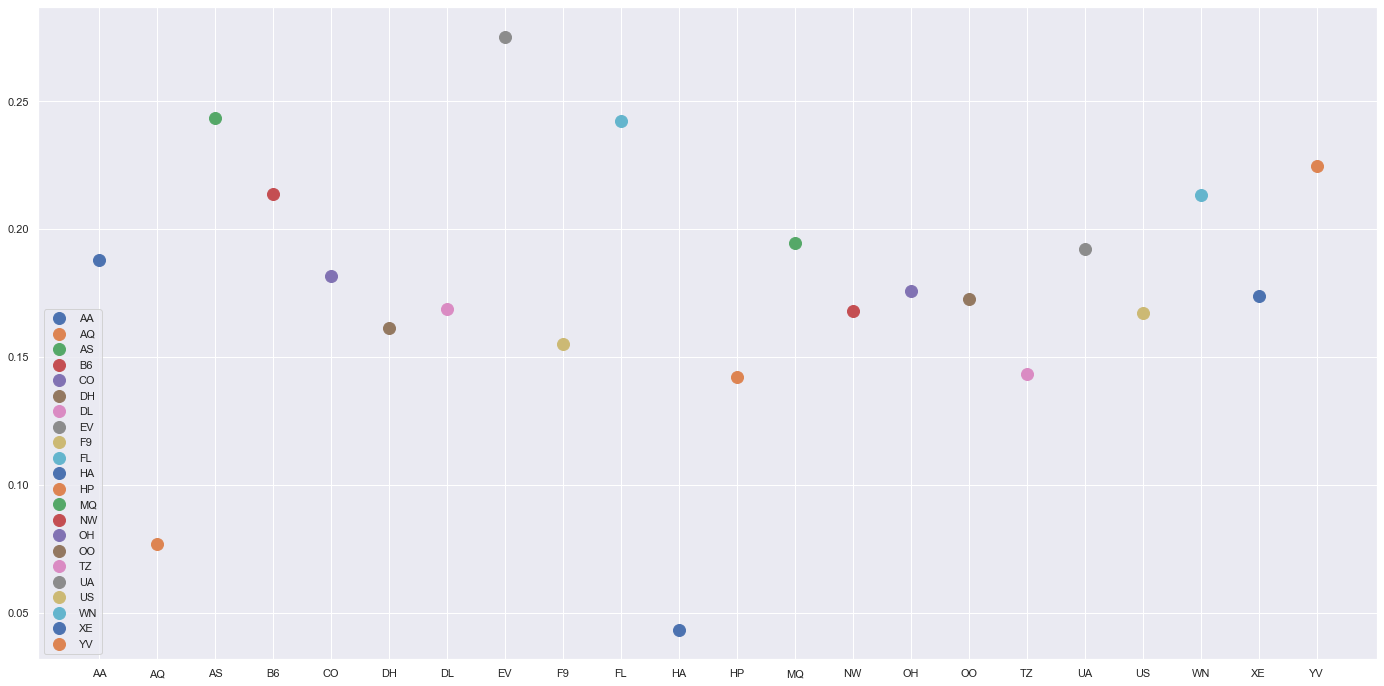

In [72]:
groups = uniq_carr.groupby('UniqueCarrier')

# Plot
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group.UniqueCarrier, group.ratio, marker='o', linestyle='', ms=12, label=name)
ax.legend()

plt.show()

Looks like a useful feature

# Origin

In [76]:
origin = count_flight_ratio_per_column(train, 'Origin')
origin = origin.sort_values(by='ratio')

In [80]:
origin.head(20)

,Origin,dep_delayed_15min,num_of_flights,total,ratio
259,GTF,Y,1,45,0.022222
234,ITO,Y,2,68,0.029412
266,HLN,Y,1,31,0.032258
190,LIH,Y,5,153,0.032680
264,BRO,Y,1,28,0.035714
253,EKO,Y,1,26,0.038462
256,SJT,Y,1,24,0.041667
230,SGU,Y,2,43,0.046512
238,RST,Y,2,40,0.050000
224,CLL,Y,2,40,0.050000


In [79]:
origin.tail(20)

,Origin,dep_delayed_15min,num_of_flights,total,ratio
173,GNV,Y,7,23,0.304348
176,VLD,Y,6,19,0.315789
138,AGS,Y,12,37,0.324324
187,PSG,Y,6,18,0.333333
250,BLI,Y,1,3,0.333333
214,MCN,Y,3,9,0.333333
172,BET,Y,7,21,0.333333
219,TUP,Y,2,6,0.333333
209,OTZ,Y,3,9,0.333333
158,EGE,Y,9,25,0.360000


In [82]:
origin.sort_values(by='total', ascending=False).head(20)

,Origin,dep_delayed_15min,num_of_flights,total,ratio
0,ATL,Y,1506,5834,0.258142
1,ORD,Y,1254,4870,0.257495
2,DFW,Y,902,4270,0.211241
4,LAX,Y,552,3259,0.169377
7,IAH,Y,492,3048,0.161417
3,DEN,Y,575,2973,0.193407
8,PHX,Y,491,2729,0.179919
5,LAS,Y,546,2513,0.217270
13,CVG,Y,360,2346,0.153453
6,EWR,Y,538,2196,0.244991


Probably useful

# Flight

In [83]:
train['Flight'] = train['Origin'] + '-' + train['Dest']

In [84]:
flight_stat = count_flight_ratio_per_column(train, 'Flight')
flight_stat = flight_stat.sort_values(by='ratio')

In [85]:
flight_stat.head(20)

,Flight,dep_delayed_15min,num_of_flights,total,ratio
3372,HNL-SFO,Y,1,50,0.020000
3340,IAH-MIA,Y,1,42,0.023810
3430,OAK-JFK,Y,1,42,0.023810
2994,LAX-OGG,Y,1,38,0.026316
3241,RDU-ORD,Y,1,38,0.026316
3014,LAX-ONT,Y,1,35,0.028571
2035,KOA-HNL,Y,3,104,0.028846
3402,SLC-FCA,Y,1,34,0.029412
2925,IND-DFW,Y,1,34,0.029412
2995,LAX-BFL,Y,1,34,0.029412


In [86]:
flight_stat.tail(20)

,Flight,dep_delayed_15min,num_of_flights,total,ratio
3073,SRQ-BOS,Y,1,1,1.0
3477,CLE-SBN,Y,1,1,1.0
2847,TVC-MQT,Y,1,1,1.0
2590,LAS-MSN,Y,2,2,1.0
2584,PDX-OGG,Y,2,2,1.0
3465,CID-ATL,Y,1,1,1.0
3367,IAD-BHM,Y,1,1,1.0
3269,DCA-BTR,Y,1,1,1.0
2249,RSW-CMH,Y,2,2,1.0
2252,AKN-ANC,Y,2,2,1.0


In [87]:
flight_stat.sort_values(by='total', ascending=False).head(20)

,Flight,dep_delayed_15min,num_of_flights,total,ratio
186,SAN-LAX,Y,16,217,0.073733
2,LAS-LAX,Y,40,186,0.215054
6,LGA-ORD,Y,36,184,0.195652
176,LAX-SAN,Y,17,182,0.093407
26,LAX-PHX,Y,28,181,0.154696
5,LAX-LAS,Y,37,179,0.206704
89,DCA-LGA,Y,21,178,0.117978
63,BOS-LGA,Y,23,176,0.130682
180,LGA-DCA,Y,17,173,0.098266
7,PHX-LAS,Y,34,164,0.207317


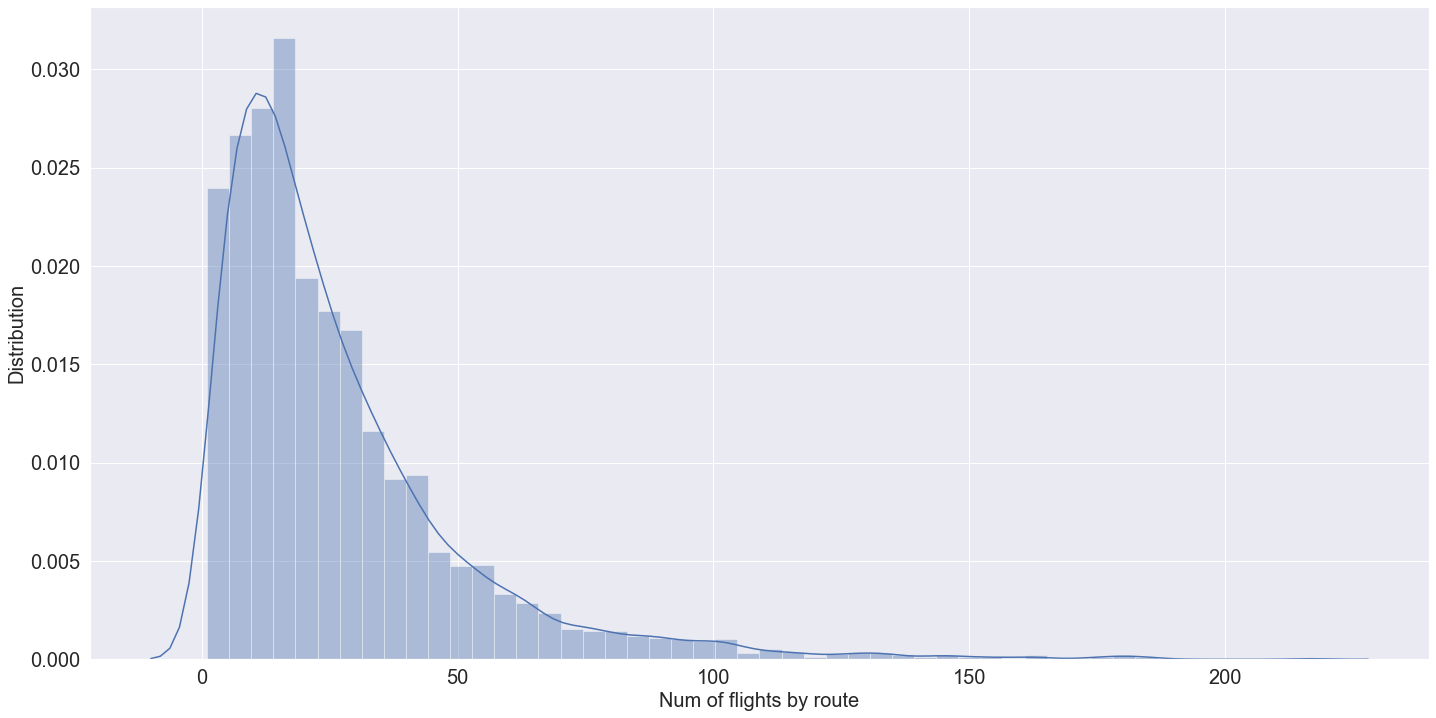

In [89]:
sns.set(rc={"figure.figsize": (24, 12)})
ax = sns.distplot(flight_stat['total'])
plt.xlabel('Num of flights by route', fontsize=20);
plt.ylabel('Distribution', fontsize=20);
plt.tick_params(axis='both', which='major', labelsize=20)
plt.show()

In [91]:
flight_stat.shape

(3553, 5)

In [90]:
flight_stat[flight_stat['total'] < 10]

,Flight,dep_delayed_15min,num_of_flights,total,ratio
2820,MAF-ELP,Y,1,9,0.111111
3266,DCA-ALB,Y,1,9,0.111111
2980,SYR-CLT,Y,1,9,0.111111
3300,PHX-FLG,Y,1,9,0.111111
2849,MAF-AUS,Y,1,9,0.111111
...,...,...,...,...,...
3039,LGA-MHT,Y,1,1,1.000000
3033,TPA-MKE,Y,1,1,1.000000
2891,MCO-CHS,Y,1,1,1.000000
3216,EKO-RNO,Y,1,1,1.000000


Not sure about this feature

# Distance

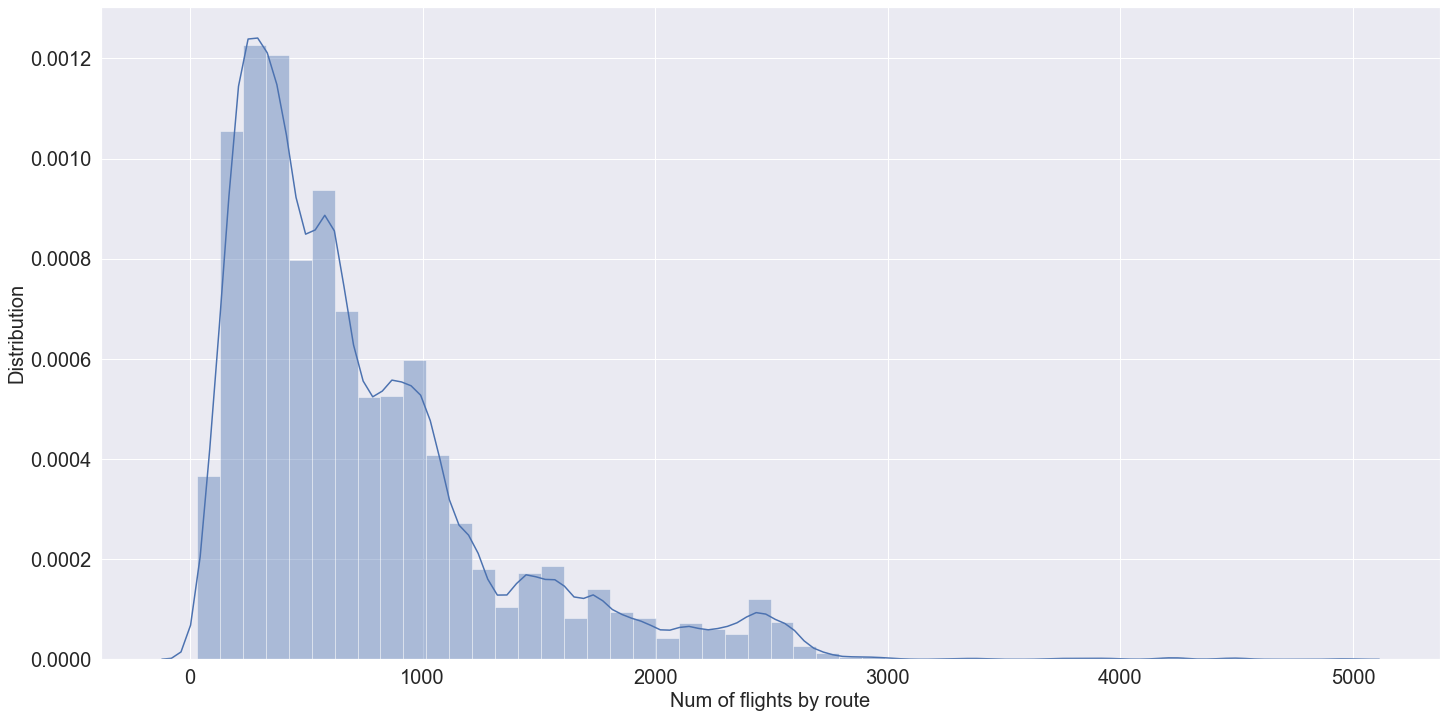

In [92]:
sns.set(rc={"figure.figsize": (24, 12)})
ax = sns.distplot(train['Distance'])
plt.xlabel('Num of flights by route', fontsize=20);
plt.ylabel('Distribution', fontsize=20);
plt.tick_params(axis='both', which='major', labelsize=20)
plt.show()

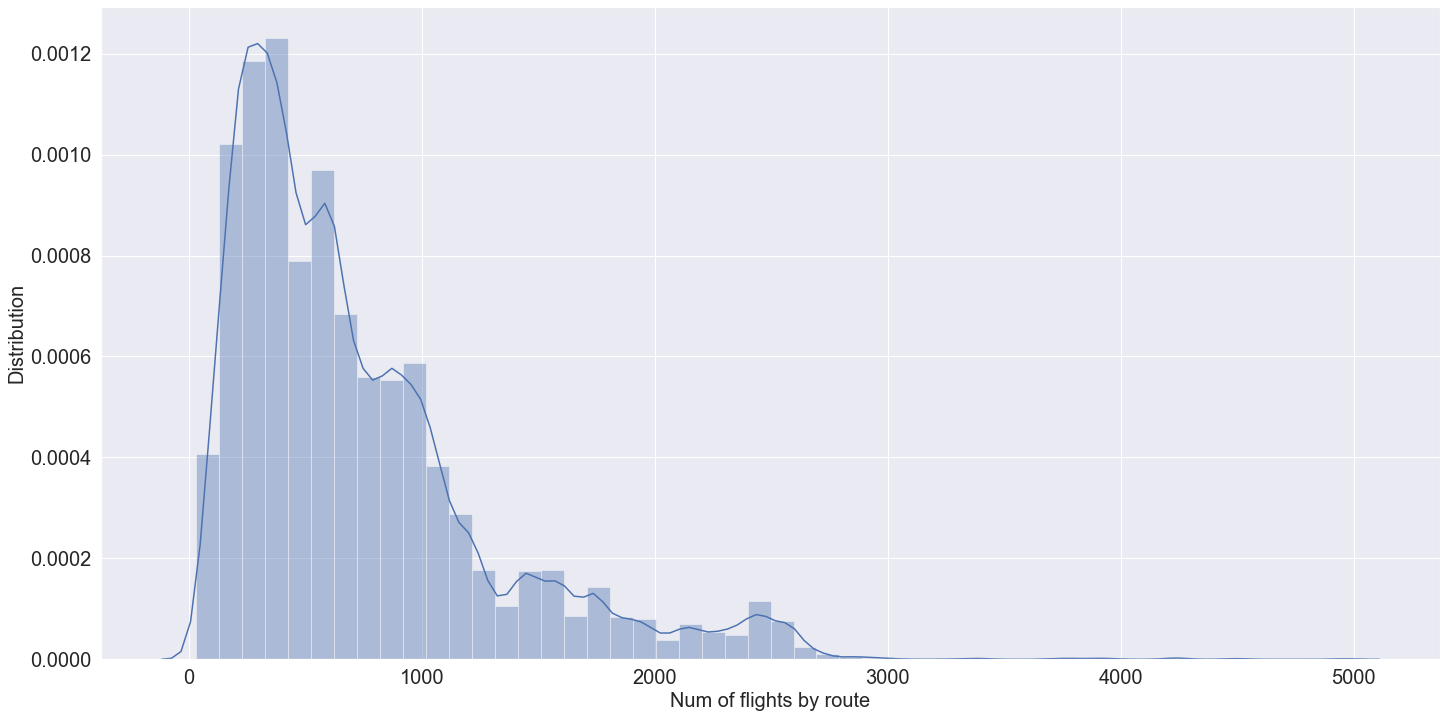

In [93]:
sns.set(rc={"figure.figsize": (24, 12)})
ax = sns.distplot(test['Distance'])
plt.xlabel('Num of flights by route', fontsize=20);
plt.ylabel('Distribution', fontsize=20);
plt.tick_params(axis='both', which='major', labelsize=20)
plt.show()

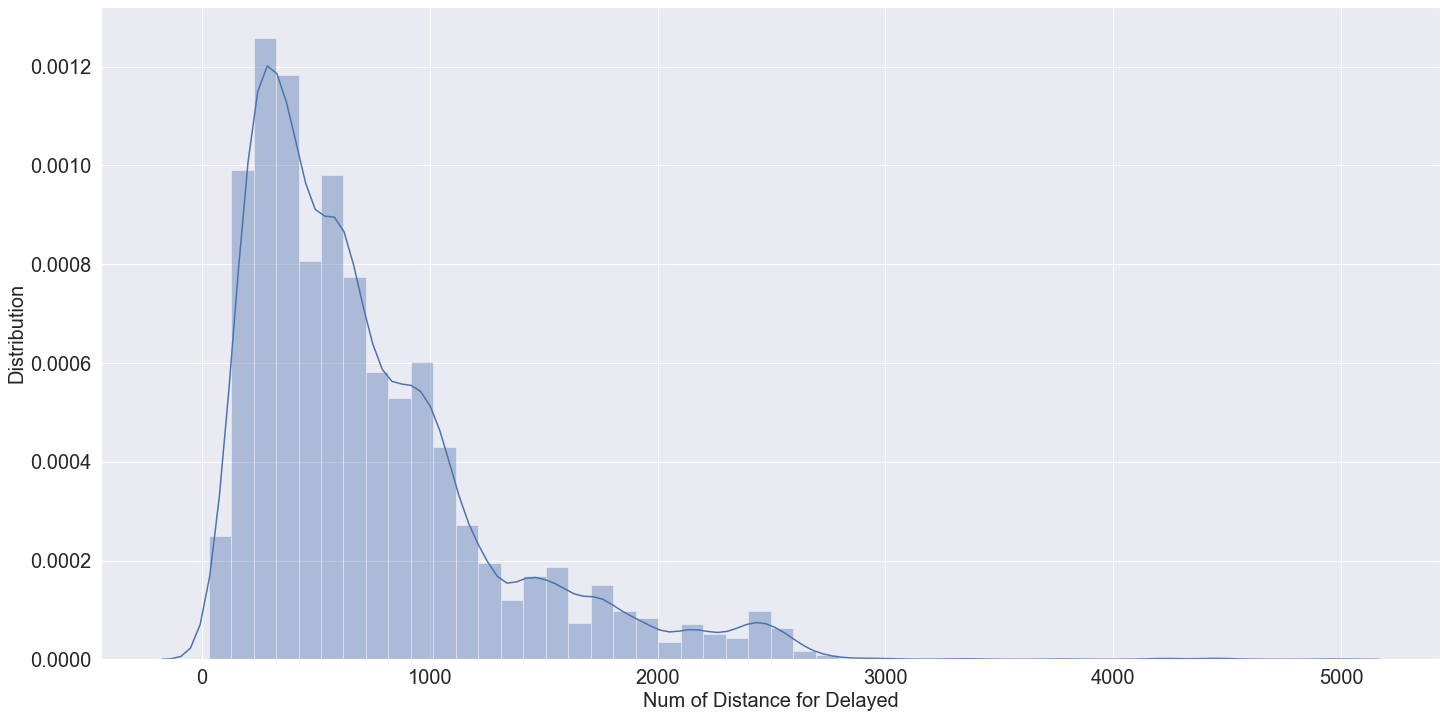

In [117]:
sns.set(rc={"figure.figsize": (24, 12)})
ax = sns.distplot(train[train.dep_delayed_15min == 'Y']['Distance'])
plt.xlabel('Num of Distance for Delayed', fontsize=20);
plt.ylabel('Distribution', fontsize=20);
plt.tick_params(axis='both', which='major', labelsize=20)
plt.show()

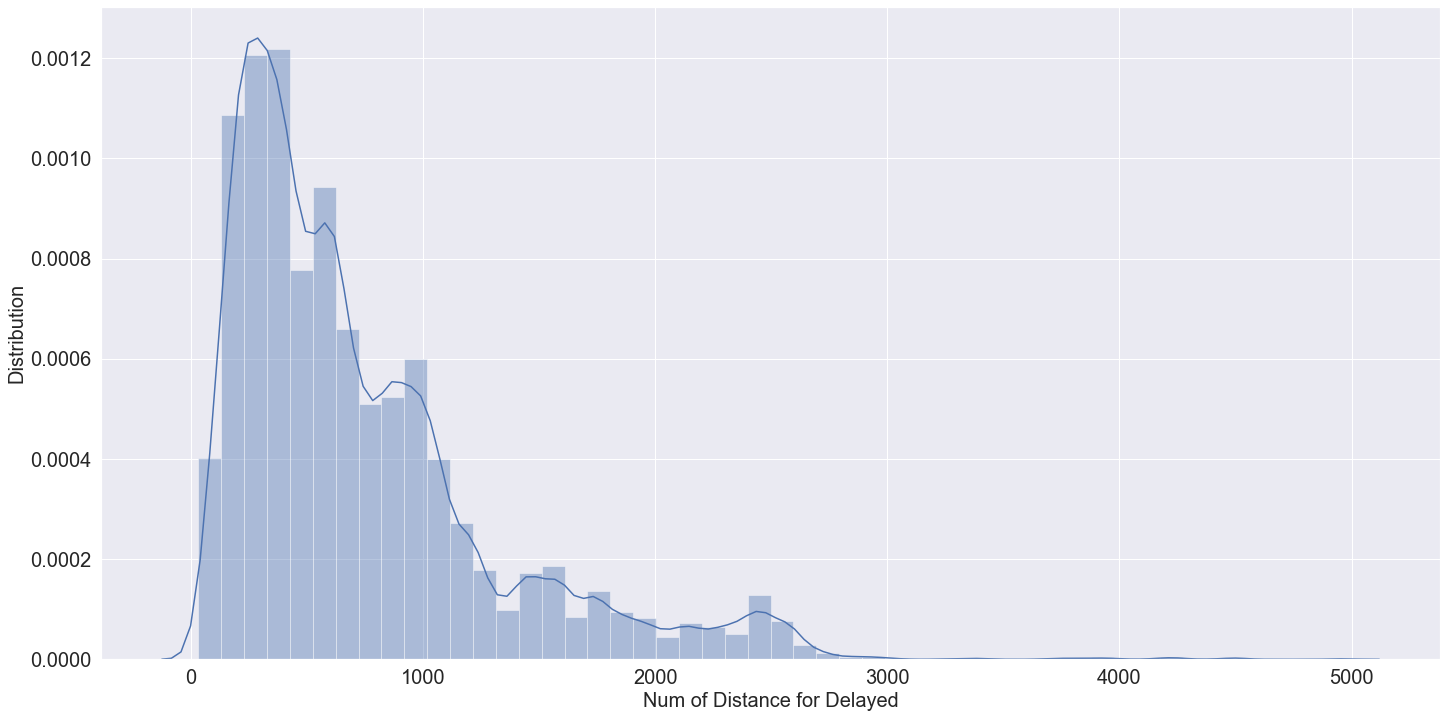

In [118]:
sns.set(rc={"figure.figsize": (24, 12)})
ax = sns.distplot(train[train.dep_delayed_15min == 'N']['Distance'])
plt.xlabel('Num of Distance for Delayed', fontsize=20);
plt.ylabel('Distribution', fontsize=20);
plt.tick_params(axis='both', which='major', labelsize=20)
plt.show()

In [94]:
dist_stat = count_flight_ratio_per_column(train, 'Distance')

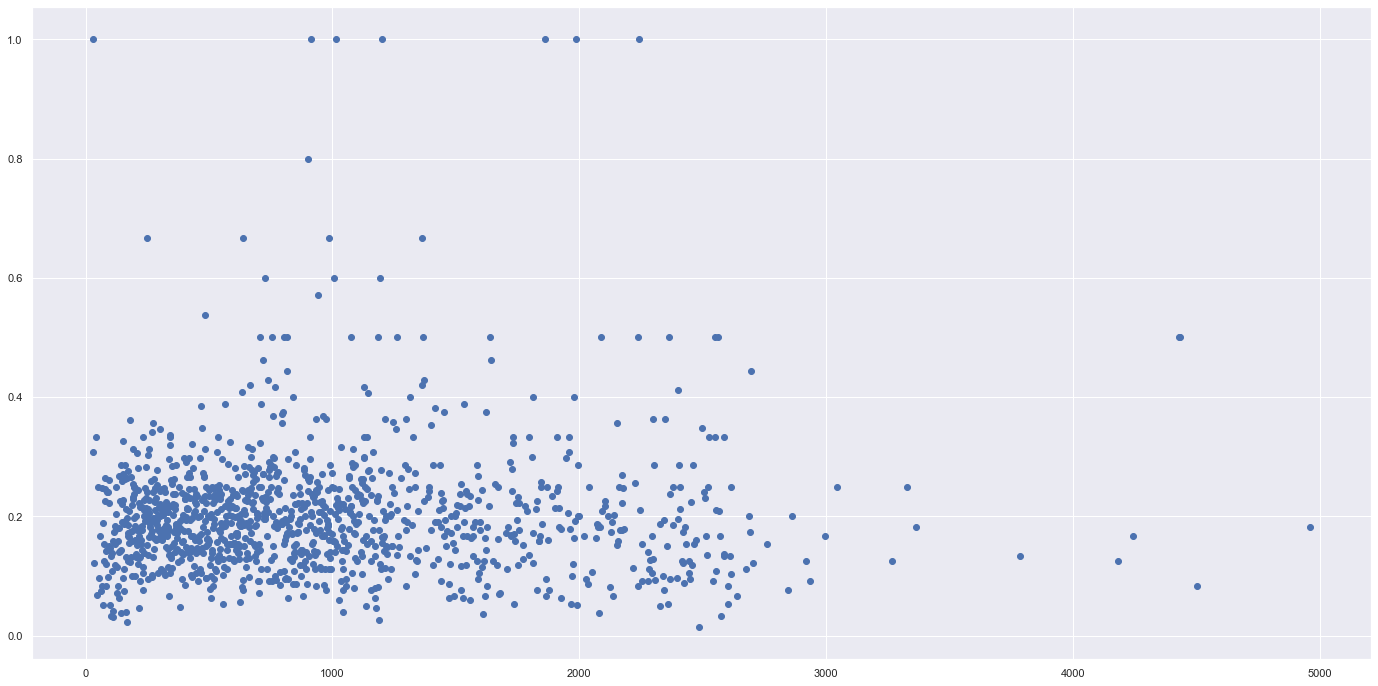

In [96]:
plt.scatter(dist_stat['Distance'], dist_stat['ratio'])

Do we need distance?

# Month + Day of Month

In [97]:
train['mon_day_of_m'] = train.apply(lambda x: x['Month'].split('-')[1] + '-' + x['DayofMonth'].split('-')[1], axis = 1)

In [98]:
train

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min,hour,Flight,mon_day_of_m
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N,19,ATL-DFW,8-21
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N,15,PIT-MCO,4-20
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N,14,RDU-CLE,9-2
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N,10,DEN-MEM,11-25
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y,18,MDW-OMA,10-7
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,c-5,c-4,c-3,1618,OO,SFO,RDD,199,N,16,SFO-RDD,5-4
99996,c-1,c-18,c-3,804,CO,EWR,DAB,884,N,8,EWR-DAB,1-18
99997,c-1,c-24,c-2,1901,NW,DTW,IAH,1076,N,19,DTW-IAH,1-24
99998,c-4,c-27,c-4,1515,MQ,DFW,GGG,140,N,15,DFW-GGG,4-27


In [100]:
m_day_m_stat = count_flight_ratio_per_column(train, 'mon_day_of_m')
m_day_m_stat = m_day_m_stat.sort_values(by='ratio')

In [101]:
m_day_m_stat.head(10)

,mon_day_of_m,dep_delayed_15min,num_of_flights,total,ratio
360,5-3,Y,20,277,0.072202
362,11-25,Y,20,268,0.074627
358,4-18,Y,21,280,0.075000
359,2-7,Y,20,261,0.076628
354,2-9,Y,22,286,0.076923
357,4-19,Y,21,270,0.077778
355,9-6,Y,22,271,0.081181
363,9-4,Y,19,233,0.081545
364,9-3,Y,19,230,0.082609
351,1-25,Y,23,278,0.082734


In [102]:
m_day_m_stat.tail(10)

,mon_day_of_m,dep_delayed_15min,num_of_flights,total,ratio
15,7-27,Y,86,264,0.325758
22,12-16,Y,83,252,0.329365
8,7-20,Y,93,281,0.330961
4,6-27,Y,99,288,0.343750
14,2-18,Y,86,248,0.346774
3,8-10,Y,106,285,0.371930
6,1-2,Y,96,251,0.382470
2,1-3,Y,108,280,0.385714
0,12-22,Y,121,305,0.396721
1,12-15,Y,118,291,0.405498


Seems like a useful feature

# Month + Day of Week

In [103]:
train['mon_day_of_w'] = train.apply(lambda x: x['Month'].split('-')[1] + '-' + x['DayOfWeek'].split('-')[1], axis = 1)

In [104]:
m_day_w_stat = count_flight_ratio_per_column(train, 'mon_day_of_w')
m_day_w_stat = m_day_w_stat.sort_values(by='ratio')

In [105]:
m_day_w_stat.head(10)

,mon_day_of_w,dep_delayed_15min,num_of_flights,total,ratio
83,11-6,Y,92,975,0.094359
82,5-6,Y,103,966,0.106625
71,5-2,Y,163,1428,0.114146
81,9-2,Y,124,1080,0.114815
80,4-2,Y,132,1144,0.115385
72,10-2,Y,160,1242,0.128824
79,9-6,Y,140,1085,0.129032
78,4-3,Y,145,1123,0.129118
77,2-3,Y,147,1125,0.130667
76,9-3,Y,151,1135,0.133040


In [106]:
m_day_w_stat.tail(10)

,mon_day_of_w,dep_delayed_15min,num_of_flights,total,ratio
18,5-5,Y,267,1121,0.238180
16,6-1,Y,272,1139,0.238806
6,6-5,Y,322,1297,0.248265
8,7-4,Y,299,1149,0.260226
9,7-3,Y,297,1116,0.266129
4,12-4,Y,332,1213,0.273702
2,7-5,Y,373,1353,0.275684
7,10-5,Y,310,1120,0.276786
1,8-4,Y,373,1333,0.279820
0,12-5,Y,428,1391,0.307692


Also can try this

# Unique Carrier + Origin

In [107]:
train['un_carr_origin'] = train['UniqueCarrier'] + '-' + train['Origin']

In [108]:
uniq_carr_origin = count_flight_ratio_per_column(train, 'un_carr_origin')
uniq_carr_origin = uniq_carr_origin.sort_values(by='ratio')

In [109]:
uniq_carr_origin.head(10)

,un_carr_origin,dep_delayed_15min,num_of_flights,total,ratio
773,HA-OGG,Y,3,131,0.022901
1015,HA-LIH,Y,2,82,0.024390
1140,NW-MSY,Y,1,36,0.027778
1188,OO-HLN,Y,1,31,0.032258
1287,FL-LAX,Y,1,29,0.034483
1141,OH-SDF,Y,1,29,0.034483
1413,XE-MAF,Y,1,29,0.034483
1253,OO-XNA,Y,1,29,0.034483
1291,XE-BRO,Y,1,28,0.035714
1203,OH-GRR,Y,1,27,0.037037


In [110]:
uniq_carr_origin.tail(10)

,un_carr_origin,dep_delayed_15min,num_of_flights,total,ratio
1335,EV-BDL,Y,1,1,1.0
1143,OH-SHV,Y,1,1,1.0
479,OH-MDW,Y,6,6,1.0
1210,OH-ILM,Y,1,1,1.0
1271,F9-ANC,Y,1,1,1.0
1360,DH-SEA,Y,1,1,1.0
1356,CO-GSO,Y,1,1,1.0
1354,CO-DAB,Y,1,1,1.0
1245,YV-GRR,Y,1,1,1.0
1178,AS-ADK,Y,1,1,1.0


In [114]:
enough_examples_carr_origin = uniq_carr_origin[uniq_carr_origin.total > 20]

In [115]:
enough_examples_carr_origin.head(10)

,un_carr_origin,dep_delayed_15min,num_of_flights,total,ratio
773,HA-OGG,Y,3,131,0.022901
1015,HA-LIH,Y,2,82,0.024390
1140,NW-MSY,Y,1,36,0.027778
1188,OO-HLN,Y,1,31,0.032258
1287,FL-LAX,Y,1,29,0.034483
1141,OH-SDF,Y,1,29,0.034483
1413,XE-MAF,Y,1,29,0.034483
1253,OO-XNA,Y,1,29,0.034483
1291,XE-BRO,Y,1,28,0.035714
1203,OH-GRR,Y,1,27,0.037037


In [116]:
enough_examples_carr_origin.tail(10)

,un_carr_origin,dep_delayed_15min,num_of_flights,total,ratio
254,XE-SYR,Y,12,34,0.352941
405,EV-EVV,Y,8,22,0.363636
340,EV-JAN,Y,9,22,0.409091
43,YV-ORD,Y,77,184,0.418478
293,OO-CLE,Y,11,26,0.423077
216,OO-SGF,Y,14,33,0.424242
238,MQ-ATL,Y,12,26,0.461538
304,EV-OMA,Y,10,21,0.476190
271,EV-MDW,Y,11,22,0.500000
282,OO-BHM,Y,11,21,0.523810


Can try but not sure that is useful